## Overview
1. Exploring the Data
2. Logistic Regression
3. __CNN__
4. Building Test Functions

In this section, I build and evaluate a CNN Model using Keras.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import glob
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import seaborn as sns


## Preparing our data

In [33]:
#get path names
path = r'/Users/john/Desktop/Demo_Day/Data/npy'
file_names = sorted(glob.glob(path +'/*.npy'))
file_names 

['/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_angel.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_sword.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_wine_glass.npy',
 '/Users/john/Desktop/Demo_Day/Data/npy/full_numpy_bitmap_yoga.npy']

In [34]:
#Get the Names of the classes
sketch_list = []
for path in file_names:
    name = (path[56:path.find('.')])
    sketch_list.append(name)
sketch_list


['angel', 'sword', 'wine_glass', 'yoga']

In [35]:
from sklearn.preprocessing import LabelEncoder

# Instantiating the encoder:
my_encoder = LabelEncoder()
my_encoder.fit(sketch_list)

LabelEncoder()

In [36]:
for i, j in enumerate(my_encoder.classes_):
    print(f'{i}:{j}')

0:angel
1:sword
2:wine_glass
3:yoga


In [37]:
my_encoder.classes_

array(['angel', 'sword', 'wine_glass', 'yoga'], dtype='<U10')

In [38]:
#load npy sketch files
X = np.load(file_names[0])[:120000,:]
y = []
for i in range(X.shape[0]):
    y.append(0)
count = 1

for i in range(1,len(file_names)):
    X = np.concatenate((X,np.load(file_names[i])[:120000,:]))
    for j in range(np.load(file_names[i])[:120000,:].shape[0]):
        y.append(count)
    count +=1

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, stratify = y, random_state = 1 )

In [40]:
#Double check training data for even spreads
print(X_train.shape)
print(len(y_train))
unique, counts = np.unique(np.array(y_train), return_counts=True)
print(dict(zip(unique, counts)))

(288000, 784)
288000
{0: 72000, 1: 72000, 2: 72000, 3: 72000}


## Formatting our Data for our model

In [48]:
# Define input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Keras model types
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (288000, 28, 28, 1)
X_test shape: (192000, 28, 28, 1)


In [49]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train)}')
num_classes = len(np.unique(y_train))
print(f'Number of classes: {num_classes}')

X range: 0-255
y values: [0 1 2 3]
Number of classes: 4


In [50]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


## Creating our CNN Model

In [14]:
# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (28, 28, 1)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Dropout(0.25))
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(num_classes+1, activation='softmax'))

CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [15]:
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

## Training our Model

In [16]:
CNN_model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 12,
              verbose = 1,
              validation_split = 0.3)

Train on 201600 samples, validate on 86400 samples
Epoch 1/12
201600/201600 [==============================] - 251s 1ms/step - loss: 0.2617 - acc: 0.9114 - val_loss: 0.1759 - val_acc: 0.9420
Epoch 2/12
201600/201600 [==============================] - 269s 1ms/step - loss: 0.1860 - acc: 0.9373 - val_loss: 0.1544 - val_acc: 0.9489
Epoch 3/12
201600/201600 [==============================] - 229s 1ms/step - loss: 0.1635 - acc: 0.9449 - val_loss: 0.1484 - val_acc: 0.9506
Epoch 4/12
201600/201600 [==============================] - 250s 1ms/step - loss: 0.1464 - acc: 0.9494 - val_loss: 0.1423 - val_acc: 0.9527
Epoch 5/12
201600/201600 [==============================] - 227s 1ms/step - loss: 0.1332 - acc: 0.9539 - val_loss: 0.1379 - val_acc: 0.9542
Epoch 6/12
201600/201600 [==============================] - 214s 1ms/step - loss: 0.1233 - acc: 0.9568 - val_loss: 0.1438 - val_acc: 0.9546
Epoch 7/12
201600/201600 [==============================] - 223s 1ms/step - loss: 0.1134 - acc: 0.9600 - val_

In [18]:
score = CNN_model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


192000/192000 [==============================] - 59s 305us/step
Test loss: 0.14173344741509572
Test accuracy: 0.9562291666666667


## Storing the Model

In [19]:
model_json = CNN_model.to_json()

In [20]:
with open('CNN_model.json','w') as json_file:
    json_file.write(model_json)

In [21]:
CNN_model.save_weights('CNN_model.h5')

## Loading the Model


In [82]:
json_file = open('Demo/CNN_model.json')
loaded_model_json = json_file.read()
json_file.close()

In [83]:
from keras.models import model_from_json
CNN_model = model_from_json(loaded_model_json)
CNN_model.load_weights("Demo/CNN_model.h5")

In [84]:
CNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

## Looking at our results

In [73]:
y_pred = CNN_model.predict_classes(X_test)

In [74]:
y_pred

array([3, 1, 1, ..., 0, 3, 2])

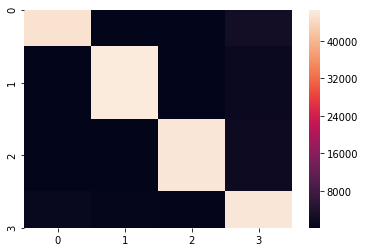

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm)

In [21]:
cm

array([[45313,   212,   117,  2358],
       [  176, 46489,   127,  1208],
       [  208,   280, 45881,  1631],
       [ 1081,   590,   416, 45913]])

In [22]:
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        if i == j:
            cm[i,j] = 0

0:angel
1:sword
2:wine_glass
3:yoga


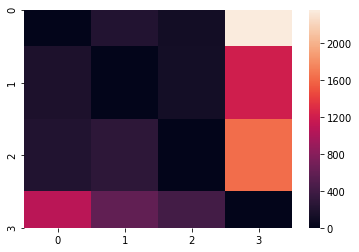

In [23]:
sns.heatmap(cm)
for i, j in enumerate(my_encoder.classes_):
    print(f'{i}:{j}')
    

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
for i, j in enumerate(my_encoder.classes_):
    print(f'{i}:{j}')

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     48000
           1       0.98      0.97      0.97     48000
           2       0.99      0.96      0.97     48000
           3       0.90      0.96      0.93     48000

    accuracy                           0.96    192000
   macro avg       0.96      0.96      0.96    192000
weighted avg       0.96      0.96      0.96    192000

0:angel
1:sword
2:wine_glass
3:yoga


## Precision and recall
Once again, Class yoga had the lowest precision score (TP/(TP + FP). Class Yoga has a higher amount of false positives. 

Class angel has the lowest recall score (TP/(TP+FN)) and a majority of its false negatives comes from Class Yoga.

CNN has significantly improved the f1-scores of all classes. In particular, the CNN recognizes yoga images much better than logistic regression.

## Looking at the misclassified photos

y_pred

In [76]:
#create dataframe, col1 = y_pred, col2 = y_test
check = {'y_pred_numeric': y_pred, 'y_test': y_test}
df = pd.DataFrame(data=check)

In [79]:
#create mask of wrong answers
wrong_answers_mask = ~(df['y_pred_numeric'] == df['y_test'])

In [80]:
#create index of wrong answers since y is a list
y_wrong_index = list(wrong_answers_mask.index[wrong_answers_mask.values == True])

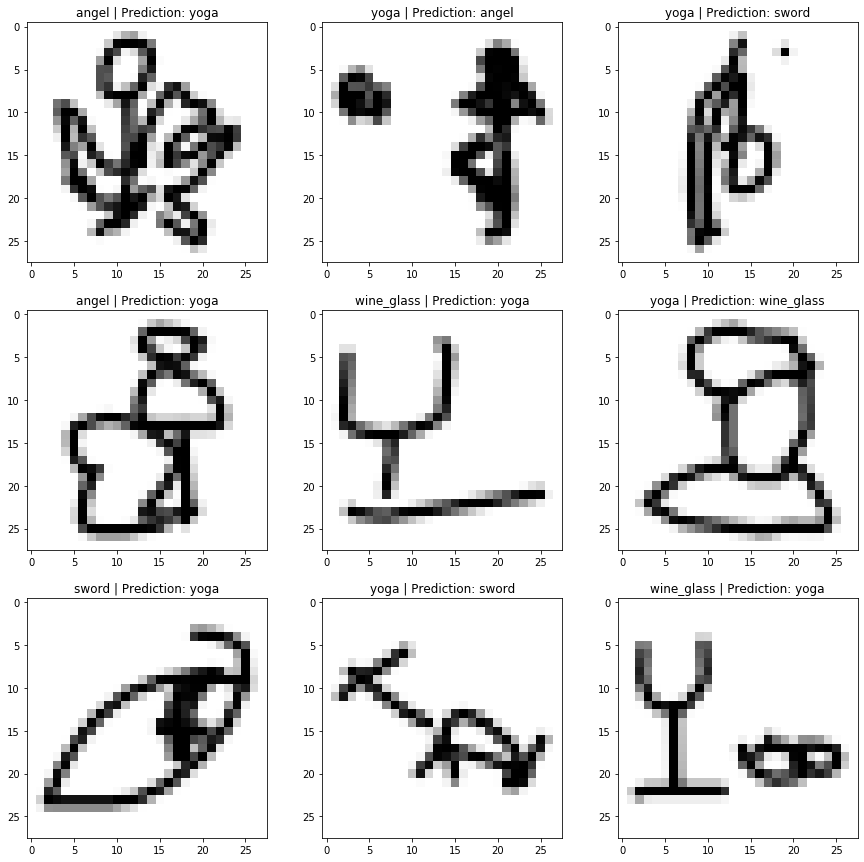

In [81]:
plt.subplots(3,3, figsize = (15,15))
for i in range(9):
    #apply mask on Xtest
    X_test_wrong= X_test[wrong_answers_mask][i].reshape(1, img_rows, img_cols, 1)
    #Predict y based on Xtest
    y_pred = CNN_model.predict(X_test_wrong)
    #must index wrong answers for test_label using y_wrong_index
    test_label = my_encoder.inverse_transform([y_test[y_wrong_index[i]]])[0]
    pred_label = my_encoder.inverse_transform([np.argmax(y_pred)])[0]
    
    
    plt.subplot(3,3,i+1)
    
    plt.title(str(test_label) + ' | Prediction: '+str(pred_label))
    plt.imshow(X_test[wrong_answers_mask][i].reshape(28,28), cmap ='Greys')
plt.show()

Looking at the mistakes, some of these photos are pretty hard even for a human to guess. 